In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as sts
import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Parameters
P = [3, 5, 1, 4]
N = 10 ** 4
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)

true_transmission_rate_mu = np.random.beta(2, 10, len(P))
true_transmission_rate_std = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_transmission_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_transmission_rate_mu, true_transmission_rate_std)
])

true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

base_rate = np.random.beta(2, 10, 1)

In [4]:
# Simulate data
data = {}
# TODO: Add covariances between same type of activity
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

In [5]:
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

In [6]:
# Stan model code
model_code = """
functions {
  real expit_gaussian_lpdf(real y, real logit_mu, real sigma2) {
    return log(1 / y + 1 / (1 - y)) - (logit(y) - logit_mu)^2 / (2 * sigma2);
  }
}
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0> K;                            // number of classes
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=1, upper=K> c[P];                // place classes
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> mu[K];              // class transmission means
  real<lower=0> sigma2[K];                   // class transmission variances
  real<lower=0, upper=1> rho;                // underlying risk
}
transformed parameters {
  // Pre-computation for efficiency
  real log1m_theta[P] = log1m(theta);
  real log1m_rho = log1m(rho);
  real logit_mu[K] = logit(mu);
}
model {
  // Priors
  mu ~ beta(1, 5);
  sigma2 ~ inv_gamma(10, 1);
  rho ~ beta(1, 3);
  
  // Likelihood (classes)
  for (p in 1:P) {
    theta[p] ~ expit_gaussian(logit_mu[c[p]], sigma2[c[p]]);
  }
  
  // Likelihood (observations)
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""" 

In [7]:
# Build model
model_data = {'N': N, 'P': sum(P), 'K': len(P), 
              'X': X.to_numpy(), 'y': y.to_numpy(), 'c': c}
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building...
Messages from stanc:
  The parameter theta has no priors.
Found model in cache. Done.


In [8]:
# Set NUTS parameters
nuts_samples = 2000
nuts_burnin = 1000
nuts_chains = 8

# Posterior sampling
start = time.time()
fit = posterior.sample(num_samples=nuts_samples, num_warmup=nuts_burnin, num_chains=nuts_chains)
print(f"{time.time() - start:.02f} seconds elapsed")

Sampling...
     0/24000 [>---------------------------]   0%  1 sec/0     
     1/24000 [>---------------------------]   0%  1 sec/26915 
     1/24000 [>---------------------------]   0% 3 secs/53875 
     1/24000 [>---------------------------]   0% 4 secs/81318 
     1/24000 [>---------------------------]   0% 5 secs/106812
     1/24000 [>---------------------------]   0% 6 secs/134566
     1/24000 [>---------------------------]   0% 7 secs/159782
     1/24000 [>---------------------------]   0% 8 secs/186784
     1/24000 [>---------------------------]   0% 9 secs/213886
     1/24000 [>---------------------------]   0% 11 secs/241327
     1/24000 [>---------------------------]   0% 12 secs/266989
     1/24000 [>---------------------------]   0% 13 secs/294217
     1/24000 [>---------------------------]   0% 14 secs/322903
     1/24000 [>---------------------------]   0% 15 secs/349087
     1/24000 [>---------------------------]   0% 16 secs/376187
     1/24000 [>----------------------

298.31 seconds elapsed


In [9]:
# Set model parameters
nuts_samples = 1000
nuts_burnin = 500
chains = 4

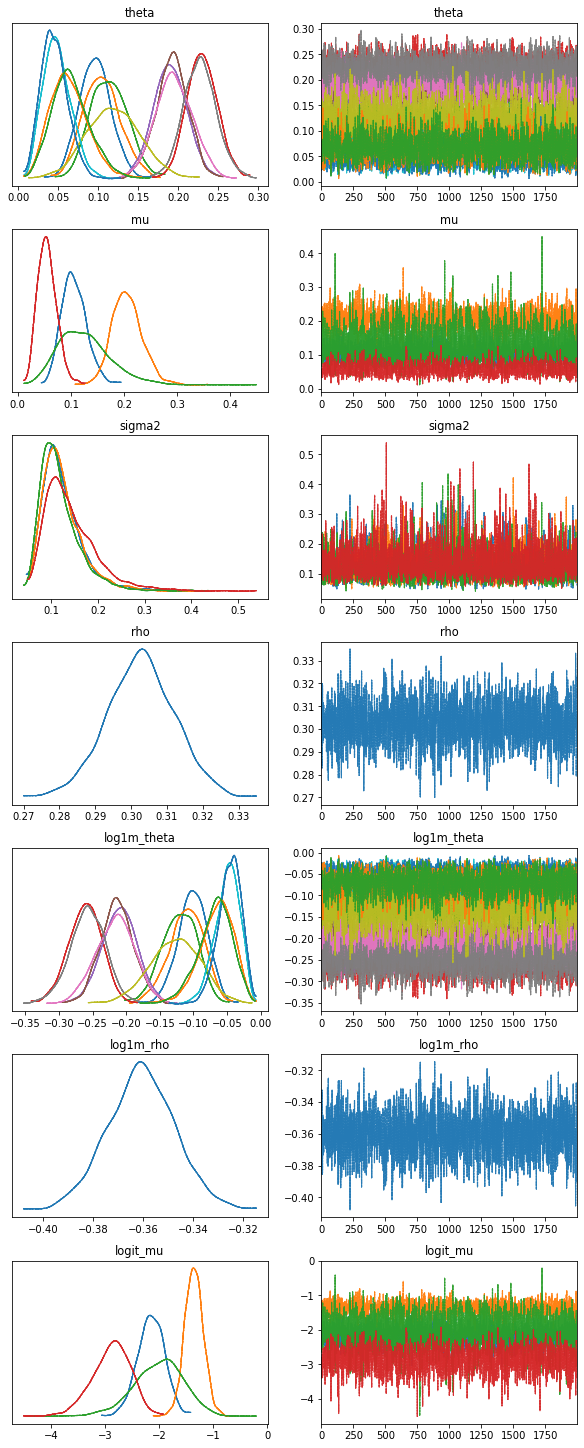

In [10]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 20));

In [11]:
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe().T

Inference on fitted model:


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,16000.0,-6632.943011,3.521341e+00,-6649.380199,-6635.017015,-6632.585871,-6630.448222,-6624.005068
accept_stat__,16000.0,0.902109,1.025225e-01,0.275248,0.860521,0.935643,0.976956,1.000000
stepsize__,16000.0,0.339475,1.021437e-13,0.339475,0.339475,0.339475,0.339475,0.339475
treedepth__,16000.0,3.708500,4.544674e-01,3.000000,3.000000,4.000000,4.000000,4.000000
n_leapfrog__,16000.0,13.816000,3.404536e+00,7.000000,15.000000,15.000000,15.000000,31.000000
divergent__,16000.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,16000.0,6643.916629,4.821613e+00,6630.290239,6640.523278,6643.495204,6646.925584,6662.692294
theta.1,16000.0,0.096009,1.971932e-02,0.032385,0.082465,0.095802,0.108920,0.166030
theta.2,16000.0,0.104402,2.284417e-02,0.040800,0.088035,0.103555,0.119263,0.177478


In [12]:
# View results
print('Ground truth:')
print(true_transmission_rate)
print(true_transmission_rate_mu)
print(true_transmission_rate_std)
print(base_rate)

Ground truth:
[0.12728974 0.09903452 0.10205938 0.21085327 0.19705141 0.21324935
 0.20501577 0.19893345 0.10316498 0.03220428 0.03387347 0.0416449
 0.03273827]
[0.11229016 0.21544007 0.1340044  0.03496042]
[0.1096814  0.10163871 0.10368757 0.10696748]
[0.30198401]
